In [32]:
%matplotlib notebook
import stingray.events as ev
import stingray.lightcurve as lc
import matplotlib.pyplot as plt
from stingray import io
from astropy.io import fits
import stingray.powerspectrum as powspec 
import stingray.crossspectrum as crossspec
import stingray.gti as sting_gti
import numpy as np
import pickle
import seaborn as sns

sns.set_context('talk')
# sns.set_style("whitegrid")
sns.set_palette("colorblind")

buff = 100
swift_start = 307671262.555
swift_stop = 307671601.041

# def lc_rebin(curve, dt_new):
#     if not dt_new%%curve.dt:
#         print('New bin size must be an integer value of the old bin size')
#         return None
#     new_time = []
#     new_counts = []
#     new_err = []
#     for g in curve.gti:
        
    

def nuproducts_to_stingray_lc(nuprod_lc_file, rebin = False, buffer = False, rebinsize=1.0, buffersize = 100.0, rebin_method='sum'):
    nuproducts_lc = fits.open(nuprod_lc_file)
    time = nuproducts_lc[1].data['TIME'] + nuproducts_lc[1].header['TSTART']
    dt = time[1]-time[0]
    counts = nuproducts_lc[1].data['RATE'] * dt
    error = nuproducts_lc[1].data['ERROR'] * dt
    mjdref = nuproducts_lc[1].header['MJDREFI'] + nuproducts_lc[1].header['MJDREFF']
    gti = [[x,y] for x,y in nuproducts_lc[2].data]
    if buffer:
        buffered_gti = []
        for x,y in gti:
            if np.abs(y-x) > 2*buffersize:
                buffered_gti.append([x+buffersize, y-buffersize])
        gti = buffered_gti
    if rebin:
        return lc.Lightcurve(time, counts, err=error, gti=gti, mjdref=mjdref).rebin(dt_new=rebinsize, method=rebin_method)
    else:
        return lc.Lightcurve(time, counts, err=error, gti=gti, mjdref=mjdref)
    
def extract_events(file_A, file_B, PI_min = 35, PI_max = 1909):
    # Extracts events for FPMA and FPMB from .evt files (assumed clean). An energy range can be specified.
    # The gtis are crossed to make sure they are the same.
    
    ev_files = [fits.open(file_A), fits.open(file_B)] 
    
    ev_data_A = ev_files[0][1].data
    ev_data_B = ev_files[1][1].data
    
    PI_mask_A = (ev_data_A['PI'] >= PI_min) * (ev_data_A['PI'] <= PI_max)
    PI_mask_B = (ev_data_B['PI'] >= PI_min) * (ev_data_B['PI'] <= PI_max)
    
    ev_gti_A = [[x,y] for x,y in ev_files[0][2].data]
    ev_gti_B = [[x,y] for x,y in ev_files[1][2].data]
    common_gti = sting_gti.cross_two_gtis(ev_gti_A, ev_gti_B)
    buffered_gti = []
    for x,y in common_gti:
        if np.abs(y-x) > 2*buff:
            buffered_gti.append([x+buff, y-buff])

    events = [ev.EventList(time=ev_data_A['TIME'][PI_mask_A], gti=buffered_gti, pi = ev_data_A['PI'][PI_mask_A], \
                       mjdref=ev_files[0][0].header['MJDREFI'] + ev_files[0][0].header['MJDREFF']), \
              ev.EventList(time=ev_data_B['TIME'][PI_mask_B], gti=buffered_gti, pi = ev_data_B['PI'][PI_mask_B], \
                       mjdref=ev_files[1][0].header['MJDREFI'] + ev_files[1][0].header['MJDREFF'])]
    ev_files[0].close()
    ev_files[1].close()
    return events


    

def split_ev_by_gti(events):
    split_ev = []
    gti = events.gti
    for g in gti:
        split_ev.append(ev.EventList(time=events.time, gti=[g], pi = events.pi, \
                       mjdref=events.mjdref))
    return split_ev

def split_ev_by_time(events, bintime=100):
    split_ev = []
    gti = events.gti
    for g in gti:
        g_len = g[1]-g[0]
        for i in range(int(np.floor(g_len/bintime))):
            split_ev.append(ev.EventList(time=events.time, gti=[[g[0]+(i*bintime), g[0]+((i+1)*bintime)]], \
                                         pi = events.pi, mjdref=events.mjdref))
    return split_ev
    

# data_dir = '/Volumes/LaCie/AstroData/J1739-285/nustar/timing/matteo_corrections/'
data_dir = '/disk/lif2/spike/J1739m285/timing/'
# plot_dir = '/Users/sean/Desktop/J1739-285/matteo_corrections/'
plot_dir = '/disk/lif2/spike/J1739m285/figures/'
# def flare_search(lc, threshold_sigma=1.5):
    

# Extract events

In [2]:
# PI_min = 35     # 3.0 keV
PI_min = 260     # 12.0 keV
PI_max = 1210   # 50.0 keV
events = extract_events(data_dir + 'nu90501343002A01_cl_regfilt_barycorr.evt', \
            data_dir + 'nu90501343002B01_cl_regfilt_barycorr.evt', PI_min=PI_min, PI_max=PI_max)

# print(events[0].time)

# FFT Search

In [56]:
nuprod_curve = nuproducts_to_stingray_lc(data_dir + 'nu90501343002A01_sr.lc', buffer=True, buffersize=buff)


<IPython.core.display.Javascript object>


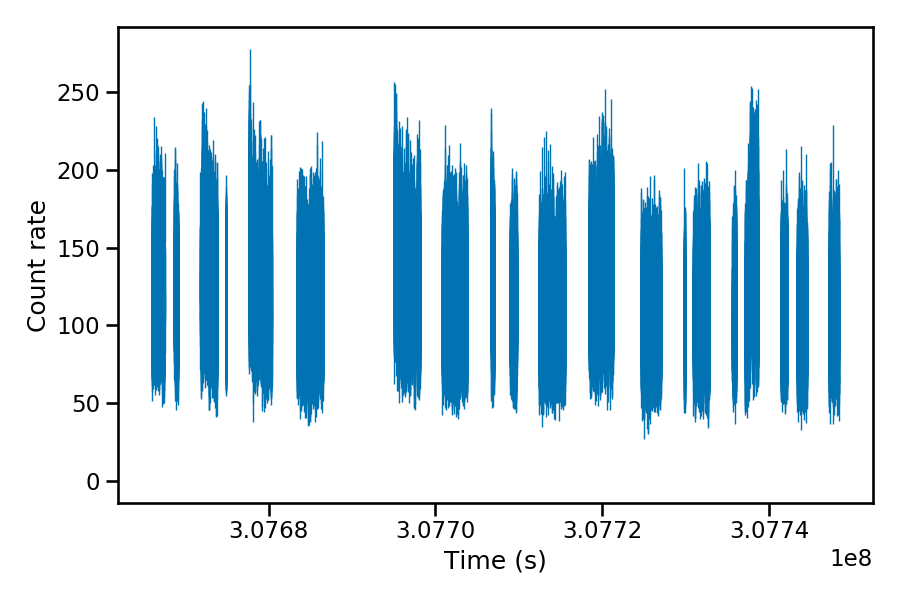

In [57]:
plt.ion()
plt.figure(figsize=(9,6))
plt.errorbar(nuprod_curve.time, nuprod_curve.countrate, xerr = nuprod_curve.dt/2, yerr=nuprod_curve.countrate_err, fmt='none', lw=1.0)
plt.xlabel('Time (s)')
plt.ylabel('Count rate')
plt.tight_layout()
# plt.savefig(plot_dir + 'light_curve_FPMA.pdf')



<IPython.core.display.Javascript object>


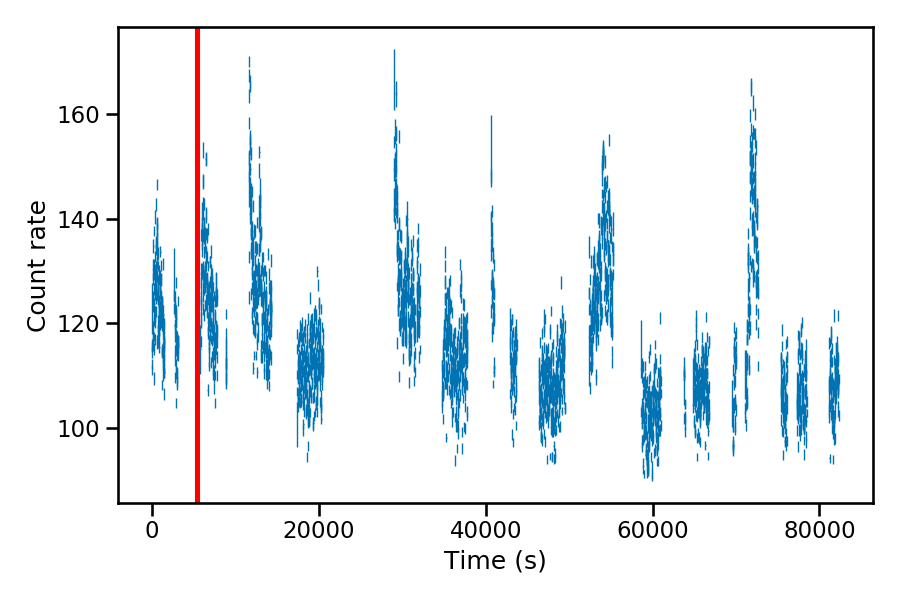

In [58]:
curve_bin = 10
plt.ion()
curve_pretty = nuprod_curve.rebin(curve_bin)
plt.figure(figsize=(9,6))
plt.errorbar(curve_pretty.time-np.min(curve_pretty.time), curve_pretty.countrate, xerr =curve_pretty.dt/2, yerr=curve_pretty.countrate_err, fmt='none', lw=1.0)
plt.xlabel('Time (s)')
plt.ylabel('Count rate')
plt.axvspan(swift_start - np.min(curve_pretty.time), swift_stop - np.min(curve_pretty.time), color='red')
plt.tight_layout()
# plt.savefig(plot_dir + 'light_curve_FPMA.pdf')


In [6]:
split_time = 256
ms_bin = 0.00025
split_A = split_ev_by_time(events[0], bintime = split_time)
curves_A = [x.to_lc(dt = ms_bin) for x in split_A]
split_A = None

split_B = split_ev_by_time(events[1], bintime = split_time)
curves_B = [x.to_lc(dt = ms_bin) for x in split_B]
split_B = None
# curves[0].write(data_dir + 'nu90501343002A01_cl_regfilt_barycorr_buffered_lc_ms.hdf', format_='hdf5')
# curves[1].write(data_dir + 'nu90501343002B01_cl_regfilt_barycorr_buffered_lc_ms.hdf', format_='hdf5')

# curves=[]

# temp_dict = io.read('/Volumes/LaCie/AstroData/J1739-285/nustar/timing/nu90501343002A01_cl_regfilt_tc_bc_buffered_lc_ms.hdf', format_='hdf5')
# curves.append(lc.Lightcurve(time=temp_dict['time'], counts=temp_dict['counts'], gti=temp_dict['gti'], mjdref=temp_dict['mjdref'], dt=temp_dict['dt']))

# temp_dict = io.read('/Volumes/LaCie/AstroData/J1739-285/nustar/timing/nu90501343002B01_cl_regfilt_tc_bc_buffered_lc_ms.hdf', format_='hdf5')
# curves.append(lc.Lightcurve(time=temp_dict['time'], counts=temp_dict['counts'], gti=temp_dict['gti'], mjdref=temp_dict['mjdref'], dt=temp_dict['dt']))

# temp_dict=None


/disk/lif2/spike/miniconda3/lib/python3.7/site-packages/stingray/utils.py:103: UserWarning: SIMON says: Bin sizes in input time array aren't equal throughout! This could cause problems with Fourier transforms. Please make the input time evenly sampled.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


In [7]:
len(curves_B)

117

## Cospectra

In [15]:
plt.ioff()
cross_spectra = []
for i in range(len(curves_A)):
#     cross = crossspec.Crossspectrum(curves_A[i], curves_B[i]).rebin_log()
    cross = crossspec.Crossspectrum(curves_A[i], curves_B[i]).rebin(df=1)
    cross_spectra.append(cross)
    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12,8))
    ax1.errorbar(cross.freq, cross.power.real, xerr=cross.df/2, fmt='')
    ax1.set_xlim(0,2000)
    ax1.axvline(1122, ls='--', color='red')
    ax1.set_xlabel('Frequency (Hz)')
    ax1.set_ylabel('Power')
#     ax1.set_xscale('log')
#     ax1.set_yscale('log')
    ax2.errorbar(curve_pretty.time-np.min(curve_pretty.time), curve_pretty.counts/curve_pretty.dt, yerr=curve_pretty.counts_err/curve_pretty.dt, fmt='none')
    ax2.axvspan(np.min(curves_A[i].time)-np.min(curve_pretty.time),np.max(curves_A[i].time)-np.min(curve_pretty.time),  facecolor='red', alpha = 0.2)
    ax2.set_xlabel('Time (s)')
    ax2.set_ylabel(r'$\mathrm{Count\ rate\ (s^{-1})}$')
    plt.tight_layout()
    plt.savefig(plot_dir + 'cross_spectrum_' + str(split_time) + 's_' + 'segment' + str(i) + '_highE.pdf')  
#     plt.figure(figsize=(9,6))
#     plt.errorbar(cross.freq, cross.power, xerr=cross.df/2, fmt='')
#     plt.axvline(1122, ls='--', color='red')
#     plt.xlim(0,2000)
#     plt.xlabel('Frequency (Hz)')
#     plt.ylabel('Power')
#     plt.tight_layout()
#     plt.savefig(plot_dir + 'cross_spectrum_' + str(split_time) + 's_' + 'segment' + str(i) + '.pdf')
    plt.close()
    
    

/disk/lif2/spike/miniconda3/lib/python3.7/site-packages/stingray/utils.py:103: UserWarning: SIMON says: Bin sizes in input time array aren't equal throughout! This could cause problems with Fourier transforms. Please make the input time evenly sampled.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/disk/lif2/spike/miniconda3/lib/python3.7/site-packages/stingray/utils.py:103: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/disk/lif2/spike/miniconda3/lib/python3.7/site-packages/stingray/utils.py:103: UserWarning: SIMON says: Bin sizes in input time array aren't equal throughout! This could cause problems with Fourier transforms. Please make the input time evenly sampled.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/disk/lif2/spike/miniconda3/lib/python3.7/site-packages/stingray/utils.py:103: UserWarning: SIMON says: Errorbars on c

/disk/lif2/spike/miniconda3/lib/python3.7/site-packages/stingray/utils.py:103: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/disk/lif2/spike/miniconda3/lib/python3.7/site-packages/stingray/utils.py:103: UserWarning: SIMON says: Bin sizes in input time array aren't equal throughout! This could cause problems with Fourier transforms. Please make the input time evenly sampled.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/disk/lif2/spike/miniconda3/lib/python3.7/site-packages/stingray/utils.py:103: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/disk/lif2/spike/miniconda3/lib/python3.7/site-packages/stingray/utils.py:103: UserWarning: SIMON says: Bin sizes in input time array aren't equal throughout! This could cause pr

/disk/lif2/spike/miniconda3/lib/python3.7/site-packages/stingray/utils.py:103: UserWarning: SIMON says: Bin sizes in input time array aren't equal throughout! This could cause problems with Fourier transforms. Please make the input time evenly sampled.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/disk/lif2/spike/miniconda3/lib/python3.7/site-packages/stingray/utils.py:103: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/disk/lif2/spike/miniconda3/lib/python3.7/site-packages/stingray/utils.py:103: UserWarning: SIMON says: Bin sizes in input time array aren't equal throughout! This could cause problems with Fourier transforms. Please make the input time evenly sampled.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/disk/lif2/spike/miniconda3/lib/python3.7/site-packages/stingray/utils.py:103: UserWarning: SIMON says: Errorbars on c

/disk/lif2/spike/miniconda3/lib/python3.7/site-packages/stingray/utils.py:103: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/disk/lif2/spike/miniconda3/lib/python3.7/site-packages/stingray/utils.py:103: UserWarning: SIMON says: Bin sizes in input time array aren't equal throughout! This could cause problems with Fourier transforms. Please make the input time evenly sampled.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/disk/lif2/spike/miniconda3/lib/python3.7/site-packages/stingray/utils.py:103: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/disk/lif2/spike/miniconda3/lib/python3.7/site-packages/stingray/utils.py:103: UserWarning: SIMON says: Bin sizes in input time array aren't equal throughout! This could cause pr

/disk/lif2/spike/miniconda3/lib/python3.7/site-packages/stingray/utils.py:103: UserWarning: SIMON says: Bin sizes in input time array aren't equal throughout! This could cause problems with Fourier transforms. Please make the input time evenly sampled.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/disk/lif2/spike/miniconda3/lib/python3.7/site-packages/stingray/utils.py:103: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/disk/lif2/spike/miniconda3/lib/python3.7/site-packages/stingray/utils.py:103: UserWarning: SIMON says: Bin sizes in input time array aren't equal throughout! This could cause problems with Fourier transforms. Please make the input time evenly sampled.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/disk/lif2/spike/miniconda3/lib/python3.7/site-packages/stingray/utils.py:103: UserWarning: SIMON says: Errorbars on c

/disk/lif2/spike/miniconda3/lib/python3.7/site-packages/stingray/utils.py:103: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/disk/lif2/spike/miniconda3/lib/python3.7/site-packages/stingray/utils.py:103: UserWarning: SIMON says: Bin sizes in input time array aren't equal throughout! This could cause problems with Fourier transforms. Please make the input time evenly sampled.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/disk/lif2/spike/miniconda3/lib/python3.7/site-packages/stingray/utils.py:103: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/disk/lif2/spike/miniconda3/lib/python3.7/site-packages/stingray/utils.py:103: UserWarning: SIMON says: Bin sizes in input time array aren't equal throughout! This could cause pr

/disk/lif2/spike/miniconda3/lib/python3.7/site-packages/stingray/utils.py:103: UserWarning: SIMON says: Bin sizes in input time array aren't equal throughout! This could cause problems with Fourier transforms. Please make the input time evenly sampled.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/disk/lif2/spike/miniconda3/lib/python3.7/site-packages/stingray/utils.py:103: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/disk/lif2/spike/miniconda3/lib/python3.7/site-packages/stingray/utils.py:103: UserWarning: SIMON says: Bin sizes in input time array aren't equal throughout! This could cause problems with Fourier transforms. Please make the input time evenly sampled.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/disk/lif2/spike/miniconda3/lib/python3.7/site-packages/stingray/utils.py:103: UserWarning: SIMON says: Errorbars on c

/disk/lif2/spike/miniconda3/lib/python3.7/site-packages/stingray/utils.py:103: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/disk/lif2/spike/miniconda3/lib/python3.7/site-packages/stingray/utils.py:103: UserWarning: SIMON says: Bin sizes in input time array aren't equal throughout! This could cause problems with Fourier transforms. Please make the input time evenly sampled.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/disk/lif2/spike/miniconda3/lib/python3.7/site-packages/stingray/utils.py:103: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/disk/lif2/spike/miniconda3/lib/python3.7/site-packages/stingray/utils.py:103: UserWarning: SIMON says: Bin sizes in input time array aren't equal throughout! This could cause pr

<IPython.core.display.Javascript object>


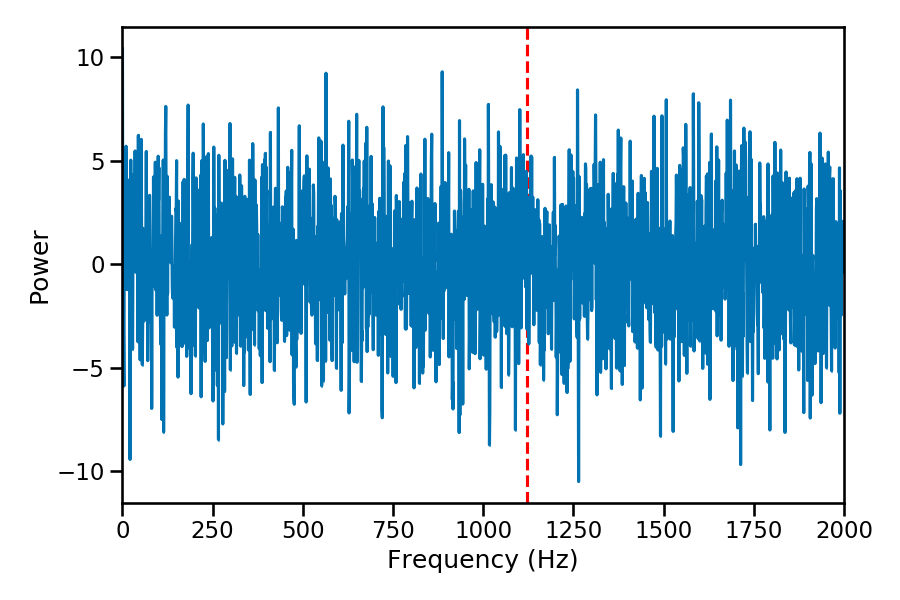

In [16]:
plt.ion()
averaged_cross_freq = cross_spectra[0].freq
averaged_cross_df = cross_spectra[0].df
averaged_cross_power = np.array([0.0 for f in averaged_cross_freq])
for cs in cross_spectra:
    averaged_cross_power = averaged_cross_power + cs.power.real
averaged_cross_power = averaged_cross_power/len(cross_spectra)
# print(averaged_cross_power)
plt.figure(figsize=(9,6))
plt.errorbar(averaged_cross_freq, averaged_cross_power, xerr=averaged_cross_df/2, fmt='')
plt.axvline(1122, ls='--', color='red')
plt.xlim(0,2000)
# plt.xscale('log')
# plt.yscale('log')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')
plt.tight_layout()
# plt.show()
plt.savefig(plot_dir + 'averaged_cross_spectrum_' + str(split_time) + 's_highE.pdf')

# HR Intensity

## 3-12 vs 12-50 keV

In [33]:
HR_binsize = 128
total_curve = nuproducts_to_stingray_lc(data_dir + 'nu90501343002A01_sr.lc', buffer=True, buffersize=buff, rebin=True, rebinsize=HR_binsize, rebin_method='sum')

soft_curves = [nuproducts_to_stingray_lc('/disk/lif2/spike/J1739m285/products_3to6keV/nu90501343002A01_sr.lc', buffer=True, rebin=True, buffersize=buff, rebinsize=HR_binsize), \
               nuproducts_to_stingray_lc('/disk/lif2/spike/J1739m285/products_6to12keV/nu90501343002A01_sr.lc', buffer=True, rebin=True, buffersize=buff, rebinsize=HR_binsize)]

hard_curves = [nuproducts_to_stingray_lc('/disk/lif2/spike/J1739m285/products_12to25keV/nu90501343002A01_sr.lc', buffer=True, rebin=True, buffersize=buff, rebinsize=HR_binsize), \
               nuproducts_to_stingray_lc('/disk/lif2/spike/J1739m285/products_25to50keV/nu90501343002A01_sr.lc', buffer=True, rebin=True, buffersize=buff, rebinsize=HR_binsize)]

soft_total = nuproducts_to_stingray_lc('/disk/lif2/spike/J1739m285/products_3to12keV/nu90501343002A01_sr.lc', buffer=True, rebin=True, buffersize=buff, rebinsize=HR_binsize)
hard_total = nuproducts_to_stingray_lc('/disk/lif2/spike/J1739m285/products_12to50keV/nu90501343002A01_sr.lc', buffer=True, rebin=True, buffersize=buff, rebinsize=HR_binsize)

# print(soft_curves[1].time == soft_curves[0].time)

common_time = total_curve.time
soft_color = (soft_curves[1].counts - soft_curves[0].counts)/(soft_curves[1].counts + soft_curves[0].counts)
soft_err = (1.0/(soft_curves[1].counts + soft_curves[0].counts))*np.sqrt(np.square((1.0-soft_color) * soft_curves[1].counts_err) + np.square((1.0+soft_color) * soft_curves[0].counts_err))

hard_color = (hard_curves[1].countrate - hard_curves[0].countrate)/(hard_curves[1].countrate + hard_curves[0].countrate)
hard_err = (1.0/(hard_curves[1].countrate + hard_curves[0].countrate))*np.sqrt(np.square((1.0-hard_color) * hard_curves[1].countrate_err) + np.square((1.0+hard_color) * hard_curves[0].countrate_err))

HR = (hard_total.countrate - soft_total.countrate)/(hard_total.countrate + soft_total.countrate)
HR_err = (1.0/(hard_total.countrate + soft_total.countrate))*np.sqrt(np.square((1.0-HR) * hard_total.countrate_err) + np.square((1.0+HR) * soft_total.countrate_err))
plt.ion()


<IPython.core.display.Javascript object>


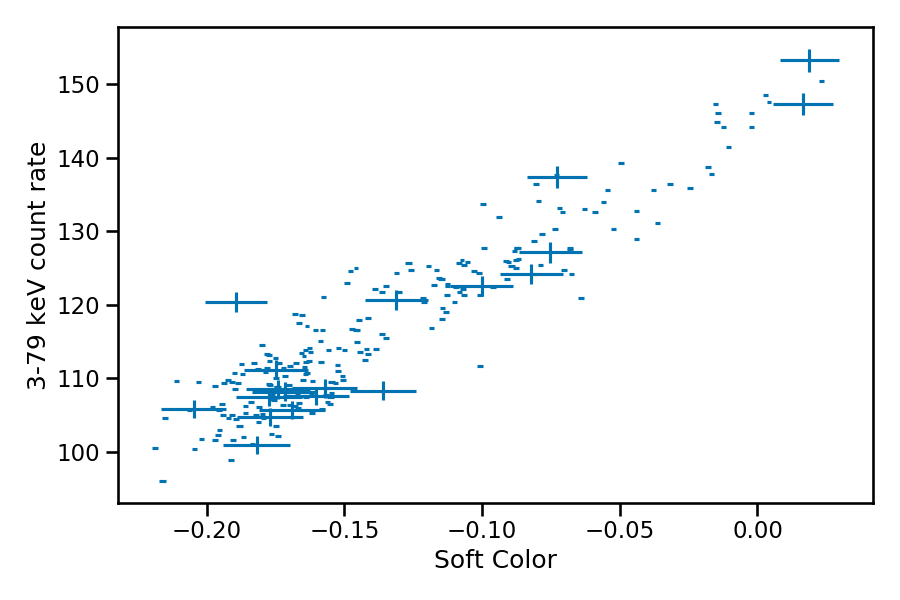

In [34]:
plt.figure(figsize=(9,6))
plt.errorbar(soft_color, total_curve.countrate, xerr = soft_err, yerr=total_curve.countrate_err, fmt='none')
plt.xlabel('Soft Color')
plt.ylabel('3-79 keV count rate')
plt.tight_layout()


<IPython.core.display.Javascript object>


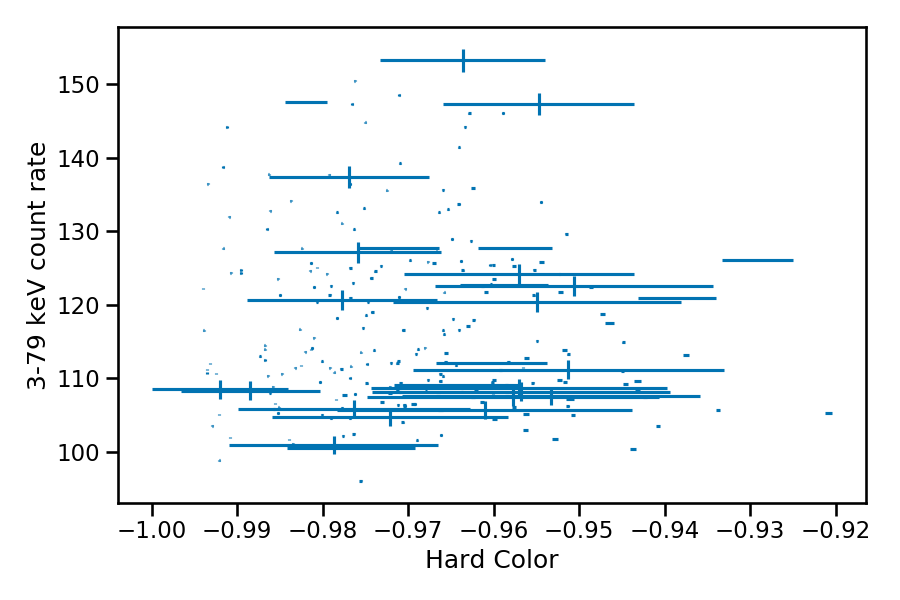

In [35]:
plt.figure(figsize=(9,6))
plt.errorbar(hard_color, total_curve.countrate, xerr = hard_err, yerr=total_curve.countrate_err, fmt='none')
plt.xlabel('Hard Color')
plt.ylabel('3-79 keV count rate')
plt.tight_layout()

<IPython.core.display.Javascript object>


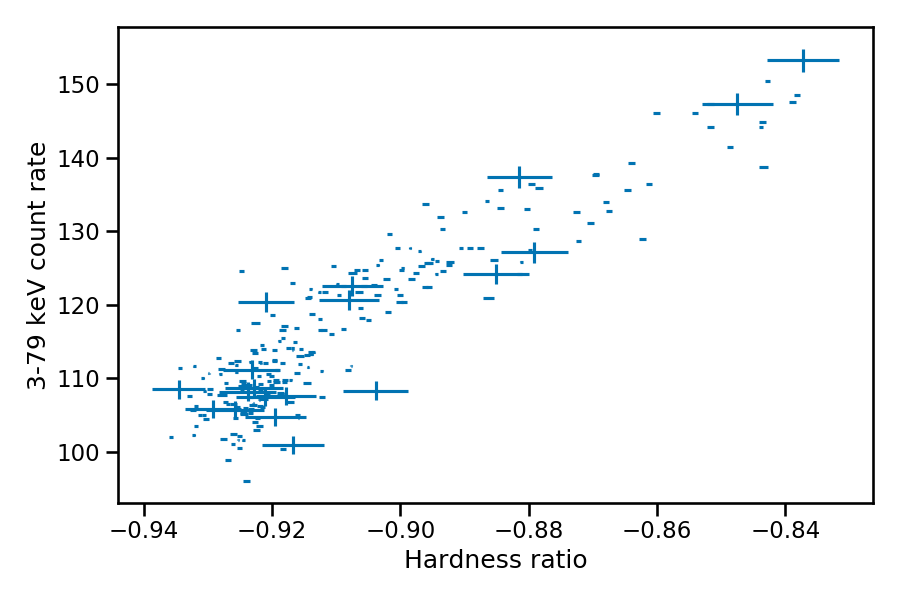

In [36]:
plt.figure(figsize=(9,6))
plt.errorbar(HR, total_curve.counts/total_curve.dt, xerr = HR_err, yerr=total_curve.counts_err/total_curve.dt, fmt='none')
plt.xlabel('Hardness ratio')
plt.ylabel('3-79 keV count rate')
plt.tight_layout()

<IPython.core.display.Javascript object>


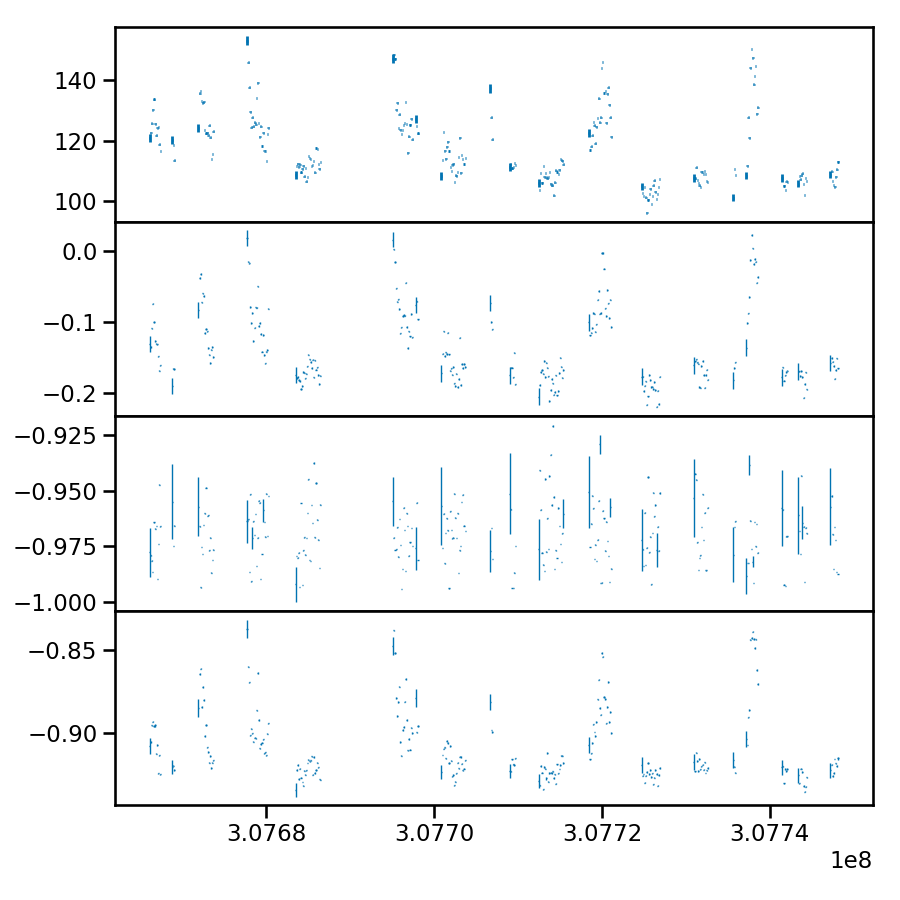

In [37]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, figsize=(9,9), sharex=True, gridspec_kw = {'height_ratios':[1,1,1,1], 'hspace':0})
ax1.errorbar(total_curve.time, total_curve.countrate, xerr = total_curve.dt/2, yerr=total_curve.countrate_err, fmt='none', lw=2.0)
ax2.errorbar(total_curve.time, soft_color, xerr = total_curve.dt/2, yerr=soft_err, fmt='none', lw=1.0)
ax3.errorbar(total_curve.time, hard_color, xerr = total_curve.dt/2, yerr=hard_err, fmt='none', lw=1.0)
ax4.errorbar(total_curve.time, HR, xerr = total_curve.dt/2, yerr=HR_err, fmt='none', lw=1.0)
plt.tight_layout()



